### Using Random Forests to predict Price Movement

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from pathlib import Path
import os, sys
import numpy as np

from numpy.random import choice
import pandas as pd
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [5]:
sns.set_style('white')
np.random.seed(seed=42)

In [6]:
results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)
    

###### Importing data prepared in data_prep.ipynb

In [7]:
with pd.HDFStore('data.h5') as store:
    data =store['CRYPTO/DAILY']
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 996 entries, 2019-05-25 to 2022-03-09
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   close    996 non-null    float64
 1   open     996 non-null    float64
 2   high     996 non-null    float64
 3   low      996 non-null    float64
 4   rsi      996 non-null    float64
 5   bb_high  996 non-null    float64
 6   bb_mid   996 non-null    float64
 7   bb_low   996 non-null    float64
 8   bb_up    996 non-null    float64
 9   bb_down  996 non-null    float64
 10  atr      996 non-null    float64
 11  natr     996 non-null    float64
 12  macd     996 non-null    float64
 13  ULTOSC   996 non-null    float64
 14  Target   996 non-null    float64
dtypes: float64(15)
memory usage: 124.5 KB


In [9]:
y = data.Target
y_binary = (y > 0).astype(int)
X = pd.get_dummies(data.drop('Target', axis=1))

##  Random Forests
### Cross Validation Parameters

In [10]:
n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

Classifier

In [11]:
rf_clf = RandomForestClassifier(n_estimators=100,             # default changed from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

Cross Validation with Default Settings

In [12]:
cv_score = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y_binary,
                           scoring='roc_auc',
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.1s finished


In [13]:


np.mean(cv_score)



0.7201388888888889

## Regression RF

In [14]:


def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)



In [15]:
rf_reg = RandomForestRegressor(n_estimators=100, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [16]:
cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


In [17]:
np.mean(cv_score)

0.2914285714285715

Parameter Tuning using GridSearchCV

In [18]:


param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}



In [19]:


gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)



In [20]:


gridsearch_clf.fit(X=X, y=y_binary)



Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.2s finished


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x0000029602AD7730>,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [21]:
joblib.dump(gridsearch_clf, results_path / 'gridsearch_clf.joblib') 

['results\\random_forest\\gridsearch_clf.joblib']

In [22]:
gridsearch_clf = joblib.load(results_path / 'gridsearch_clf.joblib') 

In [23]:
gridsearch_clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 250}

In [24]:
gridsearch_clf.best_score_

0.7493055555555557

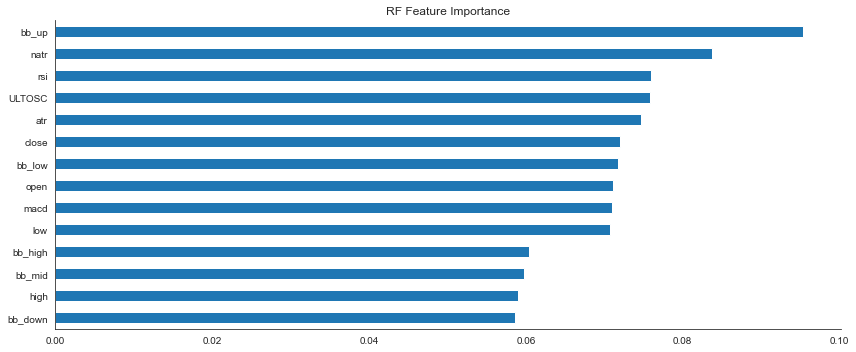

In [26]:
fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()
fig.tight_layout()

The above obtained figure shows the Normalised Feature Importance for each featured as given by SKlearn.

CV Tuning for the regressor and fitting

In [27]:
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                      cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)

In [28]:
gs_reg = gridsearch_reg

In [29]:
gridsearch_reg.fit(X=X, y=y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x0000029602AD7730>,
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring=make_scorer(rank_correl),
             verbose=1)

In [30]:


joblib.dump(gridsearch_reg, results_path / 'rf_reg_gridsearch.joblib') 



['results\\random_forest\\rf_reg_gridsearch.joblib']

In [31]:
gridsearch_reg = joblib.load(results_path / 'rf_reg_gridsearch.joblib') 

In [32]:


gridsearch_reg.best_params_



{'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 50}

In [33]:
f'{gridsearch_reg.best_score_*100:.2f}'

'26.39'

Result Comparison

In [34]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,15,5
min_samples_leaf,5,5
n_estimators,50,250


Feature Importance

In [35]:
fi_clf = gridsearch_clf.best_estimator_.feature_importances_
fi_reg = gridsearch_reg.best_estimator_.feature_importances_

In [36]:


idx = [c.replace('_', ' ').upper() for c in X.columns]



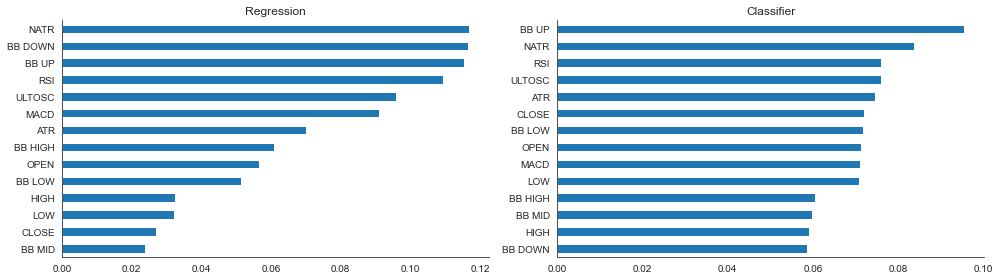

In [37]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
(pd.Series(fi_clf, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[1], title='Classifier'))
(pd.Series(fi_reg, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[0], title='Regression'))
sns.despine()
fig.tight_layout()